#### From Sheet to DataFrame to Regression Object



In [11]:
!pip install -r requirements.txt

In [12]:
#Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
Senegal_Data = '1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E'

In [13]:
import pandas as pd
import numpy as np

# === 1. Food Expenditures ===
#x = read_sheets(Senegal_Data, sheet='Food Expenditures (2019)')
x = pd.read_csv("Food_Expenditures_T(2019).csv", header= 0, index_col=0)
x = x.set_index(['i', 't', 'm', 'j']).squeeze()

# === 2. Food Prices ===
#p = read_sheets(Senegal_Data, sheet='Food Prices (2019)').set_index(['t', 'm', 'j', 'u'])
p = pd.read_csv('Food_Prices_T(2019).csv', header= 0).set_index(['t', 'm', 'j', 'u'])
p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

# Compute medians of prices for each (t, m, j, u)
p = p.groupby(['t', 'm', 'j', 'u']).median()

# Keep only Kg unit
p = p.xs('Kg', level="u").squeeze().unstack('j')

# Find intersection of goods between price data and expenditure data
common_goods = list(set(p.columns).intersection(set(x.index.get_level_values('j'))))

# Filter both datasets to those goods
p = p[common_goods].T

# === 3. Household Characteristics ===
#d = read_sheets(Senegal_Data, sheet='Household Characteristics')
d = pd.read_csv('Household_Characteristics.csv', header= 0)
d.columns.name = 'k'

# Replace blanks with zeros
d = d.replace(np.nan, 0)

# Group expenditures and clean
x = x.T.groupby(['i', 't', 'm', 'j']).sum()
x = x.replace(0, np.nan)

# Take logs of expenditures
y = np.log(x)

# Set index for household characteristics
d.set_index(['i', 't', 'm'], inplace=True)
d = d.drop(columns=["Unnamed: 0"])

FileNotFoundError: [Errno 2] No such file or directory: 'Food_Expenditures_T(2019).csv'

This gives a dataframe of household characteristics $d$ with a simple structure.



In [14]:
d.head()

NameError: name 'd' is not defined

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [7]:
y.head()

NameError: name 'y' is not defined

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [6]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [7]:
result.predicted_expenditures()

i       t     m        j                                  
221     2019  dakar    Baobab leaves (lalo)                    107.077774
                       Beef                                   3490.727220
                       Bouillon cubes (Maggi, Jumbo, etc.)      99.763717
                       Butter                                  405.592457
                       Cabbage                                 229.066960
                                                                 ...     
259812  2019  sedhiou  Sweet banana                            270.855451
                       Sweet potato                            127.259450
                       Tea                                     145.806029
                       Tomato paste                            128.557033
                       Vinegar/mustard                         144.368164
Length: 178980, dtype: float64

Now we can compare predicted log expenditures with actual:



y      yhat
i      t    m       j                                                      
221    2019 dakar   Baobab leaves (lalo)                      NaN  4.620843
                    Beef                                 8.006368  8.015458
                    Bouillon cubes (Maggi, Jumbo, etc.)       NaN  4.386137
                    Butter                                    NaN  5.472972
                    Cabbage                              4.605170  5.234584
...                                                           ...       ...
259812 2019 sedhiou Sweet banana                              NaN  5.437278
                    Sweet potato                              NaN  4.739290
                    Tea                                  4.605170  4.952530
                    Tomato paste                         4.605170  4.774056
                    Vinegar/mustard                           NaN  4.351275

[192537 rows x 2 columns]

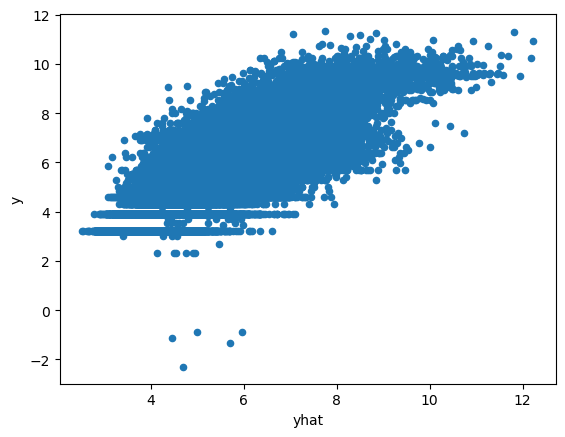

In [8]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')
df

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



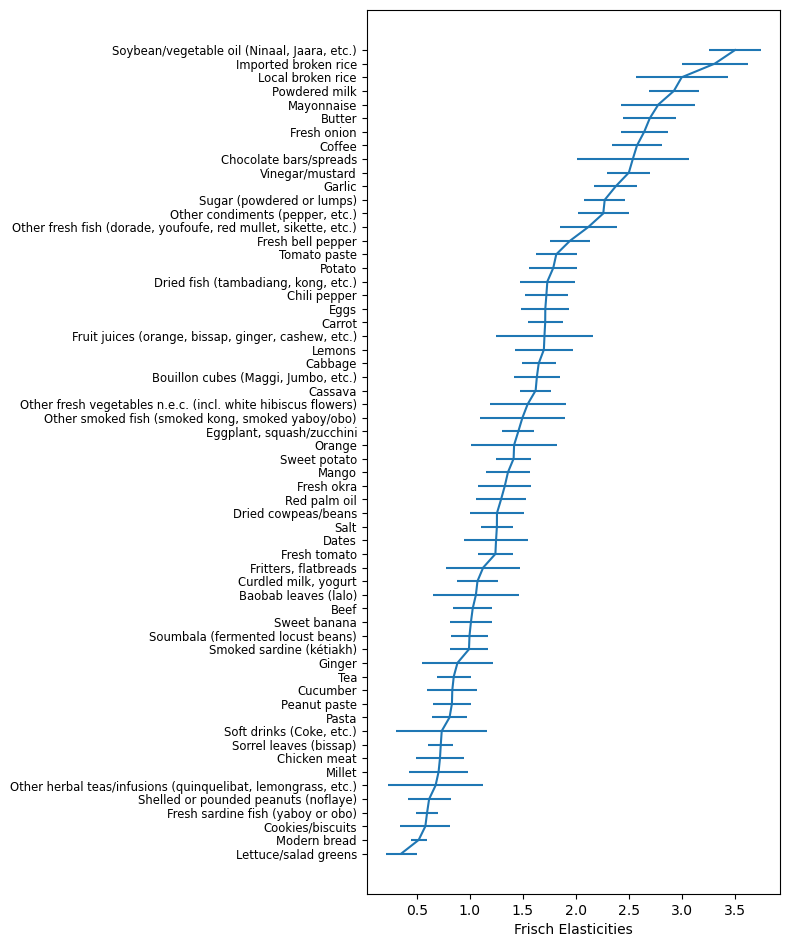

In [9]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [10]:
result.get_beta()

j
Baobab leaves (lalo)                                              1.058982
Beef                                                              1.028680
Bouillon cubes (Maggi, Jumbo, etc.)                               1.634301
Butter                                                            2.700641
Cabbage                                                           1.651856
Carrot                                                            1.712786
Cassava                                                           1.622657
Chicken meat                                                      0.719736
Chili pepper                                                      1.723880
Chocolate bars/spreads                                            2.539853
Coffee                                                            2.579637
Cookies/biscuits                                                  0.581559
Cucumber                                                          0.835879
Curdled milk, yogurt   

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [11]:
result.get_gamma()

k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
Baobab leaves (lalo),0.156074,-0.057738,0.119829,0.094122,-0.086734,0.101469,-0.059864,0.154715,-0.113262,0.109330,-0.084765,0.006962,-0.100032,-0.225432,-0.136988,-0.034275,0.028048,-0.010040,-0.143442,4.369526
Beef,0.010973,0.014437,0.007809,0.024193,-0.021695,-0.053174,-0.020634,-0.016997,-0.048001,-0.023625,0.003684,-0.024899,-0.005145,0.039727,0.036322,0.070613,0.092687,0.041588,0.066584,7.779694
"Bouillon cubes (Maggi, Jumbo, etc.)",0.958984,0.927342,-1.023663,-0.980848,1.067919,-0.886174,1.066054,-0.891818,1.021297,-0.903698,1.018609,-0.941900,1.004503,-0.917992,0.983742,-0.859130,1.014270,-0.838386,-0.093550,4.210996
Butter,-1.402476,-1.662605,-0.140015,0.130126,0.083617,1.632537,0.211181,1.701425,0.080176,1.655177,0.081098,1.599504,-0.167640,1.497435,-0.141060,1.483881,-0.153448,1.404416,0.149140,5.687287
Cabbage,1.485759,1.486260,-0.352361,-0.306158,0.354626,-1.475321,0.391012,-1.452646,0.335833,-1.485062,0.353762,-1.515886,0.361270,-1.410473,0.366828,-1.380613,0.405595,-1.412818,-0.076593,4.922622
Carrot,0.618248,0.593989,0.283169,0.366963,-0.315915,-0.576286,-0.245842,-0.589391,-0.298192,-0.618458,-0.307775,-0.633711,-0.335800,-0.540435,-0.323490,-0.526013,-0.274481,-0.550336,0.008994,4.758860
Cassava,0.080532,0.093253,-0.006438,0.057661,0.026182,-0.067455,0.011889,-0.106609,0.015078,-0.062739,-0.025121,-0.118587,-0.015486,-0.042957,0.005558,-0.033929,0.036303,-0.031614,0.058022,4.743869
Chicken meat,0.077530,-0.028237,0.041276,0.043545,0.017243,0.029811,-0.002910,0.072221,-0.098405,0.057924,-0.008123,0.036860,-0.006286,-0.068724,0.027360,-0.023436,0.161462,-0.047081,-0.047947,8.235288
Chili pepper,0.694366,0.685694,0.309956,0.386236,-0.319233,-0.703148,-0.278245,-0.662633,-0.348457,-0.695711,-0.302989,-0.708394,-0.343661,-0.626054,-0.352262,-0.614427,-0.380048,-0.652160,-0.052743,4.079933


In [17]:
### Segment by Household Type to Find Elasticities

In [26]:
# Define d for different household types

d_nuclear = d[
    (d["women"] == 1) &
    (d["men"] == 1) &
    ((d["girls"] + d["boys"]) >= 1)
]

d_single_mother = d[
    (d["women"] == 1) &
    (d["men"] == 0) &
    ((d["girls"] + d["boys"]) >= 1)
]

d_multiple_women = d[
    (d["women"] > 1) &
    (d["men"] == 1)
]

d_only_men = d[
    (d["women"] == 0) &
    (d["men"] >= 1) &
    ((d["girls"] + d["boys"]) == 0)
]